In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arnabbiswas1/microsoft-azure-predictive-maintenance")

print("Path to dataset files:", path)

/Users/miguelangellieramontano/Developer/o_repos/MAzure_Pred_Main/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/miguelangellieramontano/.cache/kagglehub/datasets/arnabbiswas1/microsoft-azure-predictive-maintenance/versions/3


In [2]:
# Standard library imports
import datetime
import math
from copy import deepcopy
from typing import Literal, Iterable, Union

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Scikit-learn imports
from sklearn.base import BaseEstimator, clone
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler


In [3]:
telemetry = pd.read_csv(f'{path}/PdM_telemetry.csv')
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [4]:
temp = pd.read_csv(f'{path}/PdM_telemetry.csv')
temp[temp['machineID']==1].shape

(8761, 6)

In [5]:
telemetry['machineID'].unique() #100 maquinas en total

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [6]:
# si hubo mantenimiento, puede haber sido programado o se debe a una falla
maint = pd.read_csv(f'{path}/PdM_maint.csv')
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


In [7]:
errors = pd.read_csv(f'{path}/PdM_errors.csv')
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


In [8]:
machines = pd.read_csv(f'{path}/PdM_machines.csv')
machines

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2
...,...,...,...
95,96,model2,10
96,97,model2,14
97,98,model2,20
98,99,model1,14


In [9]:
failures = pd.read_csv(f'{path}/PdM_failures.csv')
failures = failures.sort_values(by='datetime')
failures.reset_index(inplace=True, drop=True)
failures.head()

,datetime,machineID,failure
0,2015-01-02 03:00:00,56,comp3
1,2015-01-02 03:00:00,99,comp3
2,2015-01-02 03:00:00,83,comp4
3,2015-01-02 03:00:00,59,comp1
4,2015-01-02 03:00:00,16,comp1


In [10]:

telemetry[['volt', 'rotate', 'pressure', 'vibration']].describe()
#['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration']

,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000
mean,170.777736,446.605119,100.858668,40.385007
std,15.509114,52.673886,11.048679,5.370361
min,97.333604,138.432075,51.237106,14.877054
25%,160.304927,412.305714,93.498181,36.777299
50%,170.607338,447.558150,100.425559,40.237247
75%,181.004493,482.176600,107.555231,43.784938
max,255.124717,695.020984,185.951998,76.791072


In [11]:
machine_telemetry = machines.merge(telemetry, on=['machineID'], how='left')
machine_telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511


In [12]:
telemetry_with_failure = machine_telemetry.merge(failures, on=['datetime', 'machineID'], how='left')
telemetry_with_failure.fillna('No Failure', inplace=True)
telemetry_with_failure.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure


In [13]:
telemetry_with_f_e = telemetry_with_failure.merge(errors, on=['datetime', 'machineID'], how='left')
telemetry_with_f_e.fillna('No Error', inplace=True)
telemetry_with_f_e.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error


In [14]:
telemetry_with_f_e = telemetry_with_f_e.merge(maint, on=['datetime', 'machineID'], how='left')
telemetry_with_f_e.fillna('No Maint', inplace=True)
telemetry_with_f_e.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error,No Maint
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error,No Maint
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error,No Maint
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error,No Maint


In [15]:
telemetry_with_f_e.isnull().all()

machineID    False
model        False
age          False
datetime     False
volt         False
rotate       False
pressure     False
vibration    False
failure      False
errorID      False
comp         False
dtype: bool

In [16]:
def str_to_date(date_array, format):
    new_datetime = list()
    for date in date_array:
        new_datetime.append(datetime.datetime.strptime(date, format))
    return new_datetime

In [17]:
datetime_column = str_to_date(telemetry_with_f_e['datetime'], '%Y-%m-%d %H:%M:%S')

In [18]:
telemetry_with_f_e['datetime'] = datetime_column
telemetry_with_f_e['datetime'].min(), telemetry_with_f_e['datetime'].max()

(Timestamp('2015-01-01 06:00:00'), Timestamp('2016-01-01 06:00:00'))

# Hours to fail

In [19]:
def hours_estimation(machine_id):
    df: pd.DataFrame = telemetry_with_f_e[telemetry_with_f_e['machineID'] == machine_id]
    df.reset_index(drop=True, inplace=True)
    rul = []
    cont = len(df['failure']) - 1
    diff = 0
    while cont >= df.index.min():
        if df['failure'][cont] == 'No Failure':
            diff = diff + 1
            rul.append(diff)

        else:
            rul.append(0)
            diff = 0
        diff = rul[-1]
        cont = cont - 1
    df['hours_to_fail'] = list(reversed(rul))
    return df

In [20]:
dfs = []

machine_ids = np.arange(1, 101)
len(machine_ids)

for machine_id in machine_ids:
    df = hours_estimation(machine_id)
    dfs.append(df)

telemetry = pd.DataFrame()
for df in dfs:
    telemetry = pd.concat([telemetry, df], axis=0)

/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_39652/3162706670.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hours_to_fail'] = list(reversed(rul))
/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_39652/3162706670.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hours_to_fail'] = list(reversed(rul))
/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_39652/3162706670.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [21]:
telemetry['Error'] = telemetry['errorID'].apply(lambda x: 0 if x=='No Error' else 1)
telemetry['Failure'] = telemetry['failure'].apply(lambda x: 0 if x=='No Failure' else 1)

In [22]:
telemetry['errors'] = telemetry.groupby(['machineID'])['Error'].cumsum()
telemetry['failures'] = telemetry.groupby(['machineID'])['Failure'].cumsum()

In [23]:
telemetry = telemetry.drop(columns=['Error', 'Failure'])
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp,hours_to_fail,errors,failures
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint,96,0,0
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error,No Maint,95,0,0
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error,No Maint,94,0,0
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error,No Maint,93,0,0
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error,No Maint,92,0,0


In [24]:
telemetry['maint'] = pd.factorize(telemetry['comp'])[0]
telemetry.drop(columns=['comp'])
telemetry

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp,hours_to_fail,errors,failures,maint
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint,96,0,0,0
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error,No Maint,95,0,0,0
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error,No Maint,94,0,0,0
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error,No Maint,93,0,0,0
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error,No Maint,92,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,100,model4,5,2016-01-01 02:00:00,179.438162,395.222827,102.290715,50.771941,No Failure,No Error,No Maint,5,31,3,0
8762,100,model4,5,2016-01-01 03:00:00,189.617555,446.207972,98.180607,35.123072,No Failure,No Error,No Maint,4,31,3,0
8763,100,model4,5,2016-01-01 04:00:00,192.483414,447.816524,94.132837,48.314561,No Failure,No Error,No Maint,3,31,3,0
8764,100,model4,5,2016-01-01 05:00:00,165.475310,413.771670,104.081073,44.835259,No Failure,No Error,No Maint,2,31,3,0


In [25]:
telemetry['seconds_to_fail'] = telemetry['hours_to_fail'] * 3600
telemetry.drop('hours_to_fail', axis=1, inplace=True)
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp,errors,failures,maint,seconds_to_fail
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint,0,0,0,345600
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error,No Maint,0,0,0,342000
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error,No Maint,0,0,0,338400
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error,No Maint,0,0,0,334800
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error,No Maint,0,0,0,331200


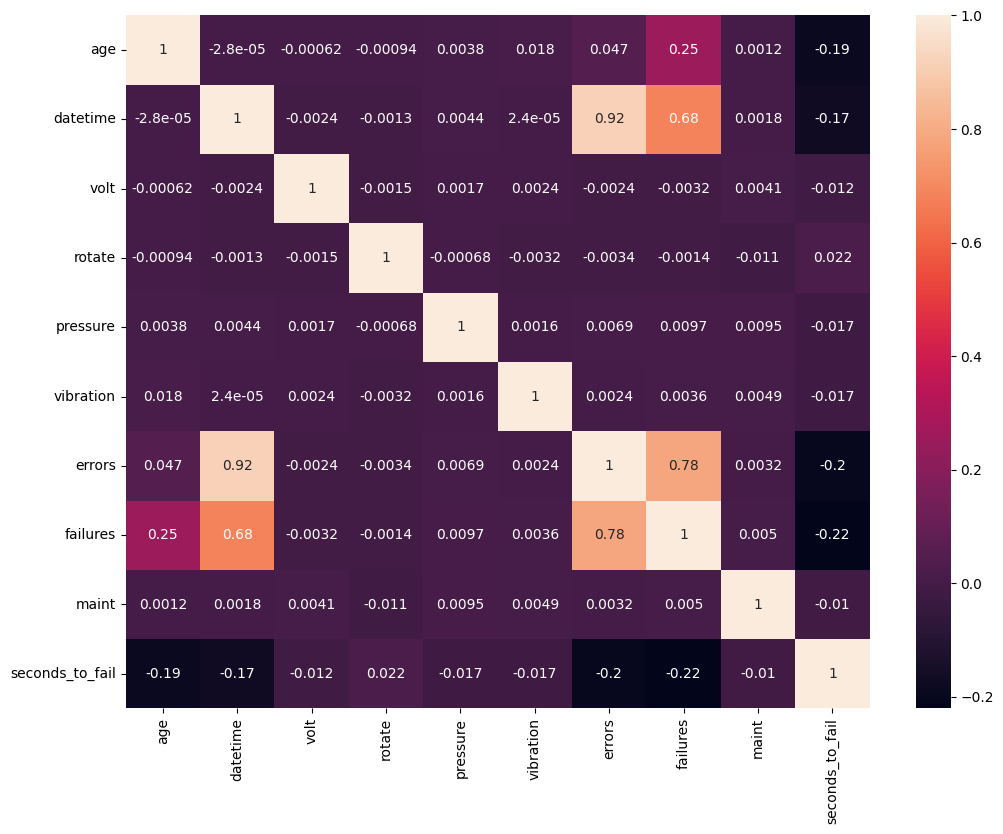

In [26]:
sns.heatmap(telemetry.drop(['machineID', 'model', 'failure', 'errorID', 'comp'], axis = 1).corr(), annot=True).figure.set_size_inches(12, 9)

In [27]:
datetimes = telemetry['datetime']
timestamps = list()
for datetime_ in datetimes:
    timestamps.append(datetime.datetime.timestamp(datetime_))    
datetimes.shape[0], len(timestamps)
telemetry['timestamp'] = timestamps
#telemetry.drop('datetime', axis=1, inplace=True)
#telemetry = telemetry[['timestamp', 'machineID', 'model', 'age', 'volt', 'rotate', 'pressure', 'vibration', 'failure', 'seconds_to_fail']]
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp,errors,failures,maint,seconds_to_fail,timestamp
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint,0,0,0,345600,1.420114e+09
1,1,model3,18,2015-01-01 07:00:00,162.879223,402.747490,95.460525,43.413973,No Failure,No Error,No Maint,0,0,0,342000,1.420117e+09
2,1,model3,18,2015-01-01 08:00:00,170.989902,527.349825,75.237905,34.178847,No Failure,No Error,No Maint,0,0,0,338400,1.420121e+09
3,1,model3,18,2015-01-01 09:00:00,162.462833,346.149335,109.248561,41.122144,No Failure,No Error,No Maint,0,0,0,334800,1.420124e+09
4,1,model3,18,2015-01-01 10:00:00,157.610021,435.376873,111.886648,25.990511,No Failure,No Error,No Maint,0,0,0,331200,1.420128e+09


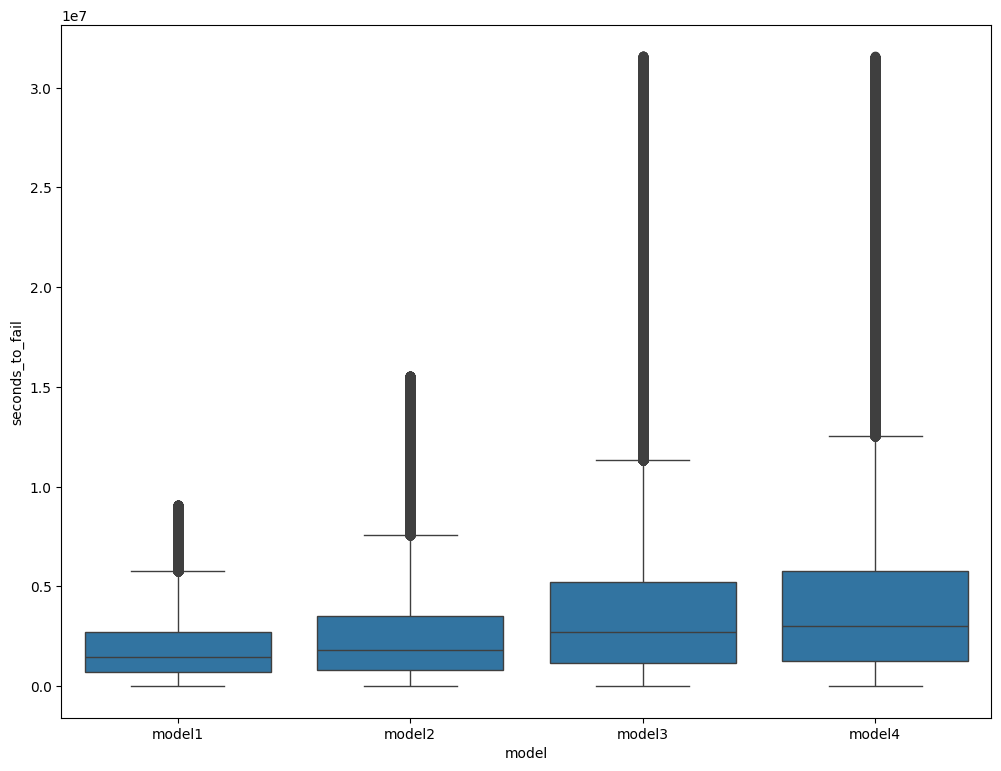

In [28]:
sns.boxplot(x=telemetry['model'], y=telemetry['seconds_to_fail'], order=['model1', 'model2', 'model3', 'model4']).figure.set_size_inches(12, 9)

In [29]:
# model3_data = telemetry[telemetry['model'] == 'model3'].reset_index(drop=True)
# model3_data.head()

Se organiza en pasos dependo del tiempo de cada uno de las maquinas, desde el 1 hasta su ultima revision

In [30]:
def create_time_step(data, machine_id):
    machine_id_data = data[data['machineID'] == machine_id]
    time_step = np.arange(1, machine_id_data.shape[0]+1)
    machine_id_data['time_step'] = time_step
    return machine_id_data

machineIDs = telemetry['machineID'].unique()
dataframes_with_time_step = []
for machine_id in machineIDs:
    dataframes_with_time_step.append(create_time_step(telemetry, machine_id))
len(dataframes_with_time_step)

/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_39652/545078963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_id_data['time_step'] = time_step
/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_39652/545078963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  machine_id_data['time_step'] = time_step
/var/folders/w_/21dg5vqn6gx3cbhxdn6pk8th0000gp/T/ipykernel_39652/545078963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

100

In [31]:
telemetry = pd.DataFrame()
for df in dataframes_with_time_step:
    telemetry = pd.concat([telemetry, df])

telemetry.sort_values(by=['datetime'], inplace=True)
telemetry.reset_index(drop=True, inplace=True)
telemetry.head()

,machineID,model,age,datetime,volt,rotate,pressure,vibration,failure,errorID,comp,errors,failures,maint,seconds_to_fail,timestamp,time_step
0,1,model3,18,2015-01-01 06:00:00,176.217853,418.504078,113.077935,45.087686,No Failure,No Error,No Maint,0,0,0,345600,1.420114e+09,1
1,55,model3,17,2015-01-01 06:00:00,147.044702,409.767331,102.826869,29.985309,No Failure,No Error,No Maint,0,0,0,5619600,1.420114e+09,1
2,54,model2,10,2015-01-01 06:00:00,158.865540,463.154857,90.765206,40.675116,No Failure,No Error,No Maint,0,0,0,1209600,1.420114e+09,1
3,79,model3,14,2015-01-01 06:00:00,194.167651,535.302327,84.071434,35.654640,No Failure,No Error,No Maint,0,0,0,75600,1.420114e+09,1
4,99,model1,14,2015-01-01 06:00:00,168.596133,384.747105,110.921131,41.944692,No Failure,No Error,No Maint,0,0,0,75600,1.420114e+09,1


In [32]:
telemetry.drop(columns=['model', 'failure', 'errorID', 'comp', 'datetime', 'timestamp'], inplace=True)
telemetry.head()

,machineID,age,volt,rotate,pressure,vibration,errors,failures,maint,seconds_to_fail,time_step
0,1,18,176.217853,418.504078,113.077935,45.087686,0,0,0,345600,1
1,55,17,147.044702,409.767331,102.826869,29.985309,0,0,0,5619600,1
2,54,10,158.865540,463.154857,90.765206,40.675116,0,0,0,1209600,1
3,79,14,194.167651,535.302327,84.071434,35.654640,0,0,0,75600,1
4,99,14,168.596133,384.747105,110.921131,41.944692,0,0,0,75600,1


# Normalización

In [33]:
cols = list(telemetry.columns)
cols[9] = 'time_step'
cols[10] = 'seconds_to_fail'
telemetry = telemetry[cols]
telemetry

,machineID,age,volt,rotate,pressure,vibration,errors,failures,maint,time_step,seconds_to_fail
0,1,18,176.217853,418.504078,113.077935,45.087686,0,0,0,1,345600
1,55,17,147.044702,409.767331,102.826869,29.985309,0,0,0,1,5619600
2,54,10,158.865540,463.154857,90.765206,40.675116,0,0,0,1,1209600
3,79,14,194.167651,535.302327,84.071434,35.654640,0,0,0,1,75600
4,99,14,168.596133,384.747105,110.921131,41.944692,0,0,0,1,75600
...,...,...,...,...,...,...,...,...,...,...,...
877204,40,4,169.568080,455.595648,105.065630,34.255772,42,14,0,8772,3600
877205,39,0,178.480041,424.870644,79.234831,34.504028,37,8,0,8773,3600
877206,38,15,140.426314,481.873972,89.826135,38.081556,42,10,0,8772,3600
877207,37,16,192.417601,460.501263,101.107201,39.044452,43,19,0,8773,3600


In [34]:
n_telemetry = telemetry.copy(True) #8761, 10
# data_machine_x = data_machine_x.drop(['machineID'], axis=1)
n_machine = n_telemetry['machineID'].copy(deep=True)
n_telemetry.drop(columns=['machineID'], inplace=True)
n_telemetry


,age,volt,rotate,pressure,vibration,errors,failures,maint,time_step,seconds_to_fail
0,18,176.217853,418.504078,113.077935,45.087686,0,0,0,1,345600
1,17,147.044702,409.767331,102.826869,29.985309,0,0,0,1,5619600
2,10,158.865540,463.154857,90.765206,40.675116,0,0,0,1,1209600
3,14,194.167651,535.302327,84.071434,35.654640,0,0,0,1,75600
4,14,168.596133,384.747105,110.921131,41.944692,0,0,0,1,75600
...,...,...,...,...,...,...,...,...,...,...
877204,4,169.568080,455.595648,105.065630,34.255772,42,14,0,8772,3600
877205,0,178.480041,424.870644,79.234831,34.504028,37,8,0,8773,3600
877206,15,140.426314,481.873972,89.826135,38.081556,42,10,0,8772,3600
877207,16,192.417601,460.501263,101.107201,39.044452,43,19,0,8773,3600


In [35]:

scaler = MinMaxScaler(feature_range=(0,1))
n_telemetry = scaler.fit_transform(n_telemetry)
cols = list(telemetry.columns)[1:]
n_telemetry = pd.DataFrame(n_telemetry, columns=cols)
n_telemetry.insert(0,'machineID',n_machine)
#n_telemetry['machineID'] = n_machine
n_telemetry

,machineID,age,volt,rotate,pressure,vibration,errors,failures,maint,time_step,seconds_to_fail
0,1,0.90,0.499928,0.503194,0.459050,0.487945,0.000000,0.000000,0.0,0.000000,0.010944
1,55,0.85,0.315044,0.487497,0.382955,0.244020,0.000000,0.000000,0.0,0.000000,0.177953
2,54,0.50,0.389958,0.583416,0.293420,0.416676,0.000000,0.000000,0.0,0.000000,0.038304
3,79,0.70,0.613685,0.713040,0.243732,0.335588,0.000000,0.000000,0.0,0.000000,0.002394
4,99,0.70,0.451626,0.442544,0.443040,0.437181,0.000000,0.000000,0.0,0.000000,0.002394
...,...,...,...,...,...,...,...,...,...,...,...
877204,40,0.20,0.457785,0.569835,0.399574,0.312994,0.700000,0.538462,0.0,0.998975,0.000114
877205,39,0.00,0.514265,0.514632,0.207829,0.317004,0.616667,0.307692,0.0,0.999089,0.000114
877206,38,0.75,0.273100,0.617048,0.286450,0.374786,0.700000,0.384615,0.0,0.998975,0.000114
877207,37,0.80,0.602594,0.578648,0.370190,0.390338,0.716667,0.730769,0.0,0.999089,0.000114


In [36]:
telemetry[telemetry['machineID'] == 6].seconds_to_fail.to_numpy().shape

(8772,)

In [37]:
def createXY(dataset: np.ndarray,n_past):
    dataX = []
    dataY = []
    # print(dataset)
    for i in range(n_past, len(dataset)):
        # print(f"{i - n_past}:{i}, 0:{dataset.shape[1]}")
        dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
        dataY.append(dataset[i,-1])
    dataY = np.array(dataY)
    dataY.reshape((dataY.shape[0],1))
    return np.array(dataX), dataY

In [38]:
def data_per_machine(x, data_set, test=False):
    X_data_per_machine = {}
    y_data_per_machine = {}
    in_ = 71 if test else 1
    out_ = 70 + x if test else x
    for i in range(in_, out_+1):
        data_machine_x: pd.DataFrame = data_set[data_set["machineID"] == i] #8761, 10
        data_machine_x = data_machine_x.drop(['machineID'], axis=1)
        # scaler = MinMaxScaler(feature_range=(0,1))
        # scaled_mx = scaler.fit_transform(data_machine_x)
        X, y = createXY(data_machine_x.to_numpy(), 5)
        # print(X.shape)
        # print(y.shape)
        X_data_per_machine[i] = X
        y_data_per_machine[i] = y
    return X_data_per_machine, y_data_per_machine


# Entrenamiento

In [39]:
# train_size = math.ceil(normalized_telemetry.shape[0] * 0.7)
# test_and_val_size = math.ceil((normalized_telemetry.shape[0] * 0.3) / 2)
# print(f'Train size: {train_size}')
# print(f'Test and validation size: {test_and_val_size}')

In [40]:
# train_set = normalized_telemetry[:train_size]
# validation_init_index = train_size + test_and_val_size

# test_set = normalized_telemetry[train_size:validation_init_index].reset_index(drop=True)
# val_set = normalized_telemetry[validation_init_index:].reset_index(drop=True)

# train_set.shape, test_set.shape, val_set.shape

In [41]:
# X_train = train_set.drop('seconds_to_fail', axis=1)
# X_train_ds = X_train
# X_train = np.array(X_train)
# y_train = train_set['seconds_to_fail']
# y_train = np.array(y_train)

# X_test = test_set.drop('seconds_to_fail', axis=1)
# X_test = np.array(X_test)
# y_test = test_set['seconds_to_fail']
# y_test = np.array(y_test)

# X_valid = val_set.drop('seconds_to_fail', axis=1)
# X_valid = np.array(X_valid)
# y_valid = val_set['seconds_to_fail']
# y_valid = np.array(y_valid)

In [47]:
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam
from keras import Sequential

opt = Adam(learning_rate=0.001)
model=Sequential()
model.add(LSTM(15,activation='tanh', return_sequences=True ,input_shape=(5,6)))
model.add(LSTM(10,activation='tanh' ))

model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer=opt, loss = "mse")

/Users/miguelangellieramontano/Developer/o_repos/MAzure_Pred_Main/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [43]:
n_telemetry

,machineID,age,volt,rotate,pressure,vibration,errors,failures,maint,time_step,seconds_to_fail
0,1,0.90,0.499928,0.503194,0.459050,0.487945,0.000000,0.000000,0.0,0.000000,0.010944
1,55,0.85,0.315044,0.487497,0.382955,0.244020,0.000000,0.000000,0.0,0.000000,0.177953
2,54,0.50,0.389958,0.583416,0.293420,0.416676,0.000000,0.000000,0.0,0.000000,0.038304
3,79,0.70,0.613685,0.713040,0.243732,0.335588,0.000000,0.000000,0.0,0.000000,0.002394
4,99,0.70,0.451626,0.442544,0.443040,0.437181,0.000000,0.000000,0.0,0.000000,0.002394
...,...,...,...,...,...,...,...,...,...,...,...
877204,40,0.20,0.457785,0.569835,0.399574,0.312994,0.700000,0.538462,0.0,0.998975,0.000114
877205,39,0.00,0.514265,0.514632,0.207829,0.317004,0.616667,0.307692,0.0,0.999089,0.000114
877206,38,0.75,0.273100,0.617048,0.286450,0.374786,0.700000,0.384615,0.0,0.998975,0.000114
877207,37,0.80,0.602594,0.578648,0.370190,0.390338,0.716667,0.730769,0.0,0.999089,0.000114


In [44]:
# Results=pd.DataFrame()
# N_MACHINE = 20
# N_BATCH = 10
# BATCH_SIZE = 70/N_BATCH
# for batch in range(0,N_BATCH):
#     X_batch, y_batch = np.array([]), np.array([])
#     for i in range(BATCH_SIZE*batch+1, BATCH_SIZE*(batch+1)+1):
#         print("Iteration #",i)#cada iteracion tarda 10 segundos

#         trainX,trainY = data_per_machine(i, n_telemetry) #(8767,n_features) (8767,)
#         X_batch.append(trainX)
#         y_batch.append(trainY)
        
# history=model.fit(X_batch, y_batch, epochs = 100, batch_size=100, validation_split=.2, verbose=0)
# Results["Machine",i] = history.history["loss"]

In [45]:
n_telemetry = n_telemetry.drop(columns=['age', 'time_step', 'errors', 'failures'])

In [48]:
Results=pd.DataFrame()
N_MACHINES_TRAIN = 70
EPOCHS = 3
trainX, trainY = data_per_machine(N_MACHINES_TRAIN, n_telemetry)

for i in tqdm(range(1, EPOCHS)):
    for i in range(1,N_MACHINES_TRAIN+1):
        print("Iteration #",i)#cada iteracion tarda 10 segundos
        #(8767,n_features) (8767,)
            
        history=model.fit(trainX[i], trainY[i], epochs = 100, batch_size=100, validation_split=.2, verbose=0)
        Results["Machine",i] = history.history["loss"]


model.save(f'models/LSTM/e{EPOCHS}_m{N_MACHINES_TRAIN}_lstmv2.keras')

  0%|          | 0/2 [00:00<?, ?it/s]

Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
Iteration # 30
Iteration # 31
Iteration # 32
Iteration # 33
Iteration # 34
Iteration # 35
Iteration # 36
Iteration # 37
Iteration # 38
Iteration # 39
Iteration # 40
Iteration # 41
Iteration # 42
Iteration # 43
Iteration # 44
Iteration # 45
Iteration # 46
Iteration # 47
Iteration # 48
Iteration # 49
Iteration # 50
Iteration # 51
Iteration # 52
Iteration # 53
Iteration # 54
Iteration # 55
Iteration # 56
Iteration # 57
Iteration # 58
Iteration # 59
Iteration # 60
Iteration # 61
Iteration # 62
Iteration # 63
Iteration # 64
Iteration # 65
Iteration # 66
Iteration # 67
Iter

 50%|█████     | 1/2 [12:13<12:13, 733.19s/it]

Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
Iteration # 30
Iteration # 31
Iteration # 32
Iteration # 33
Iteration # 34
Iteration # 35
Iteration # 36
Iteration # 37
Iteration # 38
Iteration # 39
Iteration # 40
Iteration # 41
Iteration # 42
Iteration # 43
Iteration # 44
Iteration # 45
Iteration # 46
Iteration # 47
Iteration # 48
Iteration # 49
Iteration # 50
Iteration # 51
Iteration # 52
Iteration # 53
Iteration # 54
Iteration # 55
Iteration # 56
Iteration # 57
Iteration # 58
Iteration # 59
Iteration # 60
Iteration # 61
Iteration # 62
Iteration # 63
Iteration # 64
Iteration # 65
Iteration # 66
Iteration # 67
Iter

100%|██████████| 2/2 [25:11<00:00, 755.95s/it]


In [49]:
N_MACHINES_TEST = 30
test_x, test_y = data_per_machine(N_MACHINES_TEST, n_telemetry, test=True)


274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
(8768, 1)


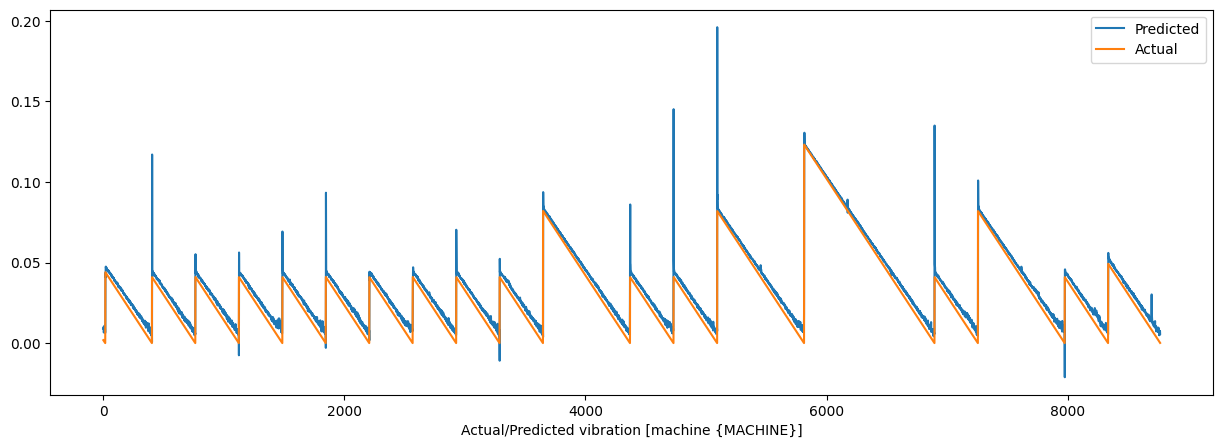

In [50]:
MACHINE = 99
y_pred = model.predict(test_x[MACHINE])

print(y_pred.shape)

plt.figure(figsize=(15 , 5))
plt.plot(y_pred,label='Predicted')
plt.plot(test_y[MACHINE],label='Actual')
plt.xlabel("Actual/Predicted vibration [machine {MACHINE}]")
plt.legend()
plt.show()

In [ ]:
test_y.shape

In [51]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_y[MACHINE], y_pred)
print(f"MSE: {mse}")

MSE: 3.185056842363182e-05


In [52]:
temp_array =np.zeros((y_pred.shape[0], scaler.n_features_in_))
temp_array[:, -1] = y_pred.flatten()
temp_array

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00877415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00869457],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01003672],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00701228],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00734253],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00578855]])

In [53]:
u_y_pred = scaler.inverse_transform(temp_array)


In [54]:
u_y_pred[0]

array([0.00000000e+00, 9.73336038e+01, 1.38432075e+02, 5.12371058e+01,
       1.48770540e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 2.77080525e+05])

In [55]:
telemetry[telemetry['machineID'] == 99].seconds_to_fail.to_numpy()

array([75600, 72000, 68400, ..., 10800,  7200,  3600])

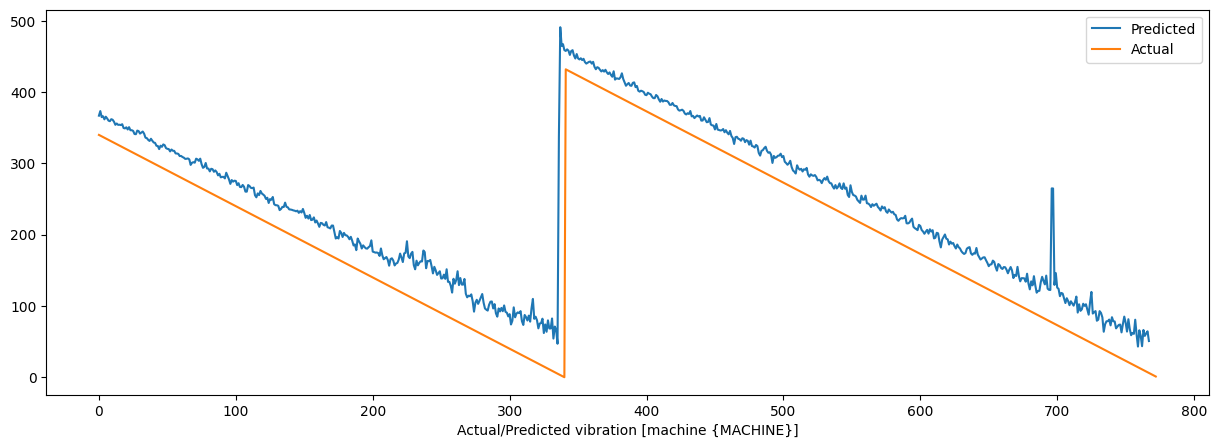

MSE: 4504.6607349686965
MAE: 42.94738042828442


In [56]:
machine_x_stf = telemetry[telemetry['machineID'] == MACHINE].seconds_to_fail.to_numpy()
plt.figure(figsize=(15 , 5))
plt.plot(u_y_pred[:,-1][8000:]/3600,label='Predicted')
plt.plot(machine_x_stf[8000:]/3600,label='Actual')
plt.xlabel("Actual/Predicted vibration [machine {MACHINE}]")
plt.legend()
plt.show()

mse = mean_squared_error(machine_x_stf[:2000]/3600, u_y_pred[:,-1][:2000]/3600)
print(f"MSE: {mse}")
mae = mean_absolute_error(machine_x_stf[:2000]/3600, u_y_pred[:,-1][:2000]/3600)
print(f"MAE: {mae}")

In [ ]:
temp = telemetry[telemetry['machineID']==1]
stf = temp['seconds_to_fail'].to_numpy()
stf

In [ ]:
temp = n_telemetry[telemetry['machineID']==1]
n_stf = temp['seconds_to_fail'].to_numpy()
n_stf

In [ ]:
plt.figure(figsize=(15 , 5))
plt.plot(stf,label='Predicted')
plt.xlabel("Actual/Predicted vibration [machine 30]")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15 , 5))
plt.plot(n_stf,label='Predicted')
plt.xlabel("Actual/Predicted vibration [machine 30]")
plt.legend()
plt.show()

In [ ]:
data_machine_x = telemetry.copy(True) #8761, 10
# data_machine_x = data_machine_x.drop(['machineID'], axis=1)
data_machine_x = data_machine_x[data_machine_x['machineID'] == 1]
scaler = MinMaxScaler(feature_range=(0,1))
scaled_mx = scaler.fit_transform(data_machine_x)
stf = scaled_mx[:,9]

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Train the model
regr = DecisionTreeRegressor(random_state=42)
regr.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(26,8))
plot_tree(regr, feature_names=X_train_ds.columns, filled=True, rounded=True, impurity=False, fontsize=16, precision=2)
plt.tight_layout()
plt.show()

In [ ]:
from pickle import dump
with open("models/d_tree1.pkl", "wb") as f:
    dump(regr, f, protocol=5)

In [ ]:
X_test

In [ ]:
test_pred = regr.predict(X_test)
test_pred

In [ ]:
plt.plot(test_pred[:10000], color = '#451952', label = 'Datos originales')
plt.plot(y_test[:10000], color='#AE445A', label = 'Predicción')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
# mse_e = mean_squared_error(np.reshape(precios_predichos, (precios_predichos.shape[0])), np.reshape(precios_reales, (precios_reales.shape[0])))
# plt.text(0.8, 0.1, f"MSE: {round(float(mse_e),4)}", fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

plt.legend()
plt.show()
# print(f"Perdida: {mean_squared_error(np.reshape(precios_predichos, (precios_predichos.shape[0])), np.reshape(precios_reales, (precios_reales.shape[0])))}")

In [ ]:
from skl2onnx import to_onnx
onx = to_onnx(regr, X_test[:1].astype(np.float32), target_opset=12)
with open("models/d_tree1.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [ ]:
from src.models.LSTM import red_LSTM

lstm_nn = red_LSTM(6,1)

In [ ]:
X_test.shape

In [ ]:
np.ones((1, 8, 1))

In [ ]:
np.random.random((32, 10, 8))[0]

In [ ]:
a = np.random.random((100, 6))
a

In [ ]:
b=a.reshape((50,2,6))
b

In [ ]:
X_train.shape[0]*X_train.shape[1]

In [ ]:
y_train.size

In [ ]:
X_train[:-1].size

In [ ]:
21465*10*6

In [ ]:
X_train_lstm = X_train[:-1].reshape(int(X_train[:-1].shape[0]/10),10,6)
y_train_lstm = y_train[:-1].reshape(int(y_train[:-1].shape[0]/10),10,1)

In [ ]:
#entr.entrena_LM(networks[0],0,entrenamiento_8_1,EPOCAS,lr=0.01,λ =0.1)
from keras.optimizers import Adam

lstm_nn.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')
history = lstm_nn.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=64)
    #model.save_weights(f'redes/DWT_LSTM/estandar/ACTINVRB/{COMPONENTES[i]}_lr{LR}_e{EPOCAS}_batch{BS}.h5')